##A. Downloading NO₂ Level in Major Cities using Sentinel-5P and openEO

This code is designed to perform a time-series analysis of Nitrogen Dioxide (NO₂) levels in several major cities in Oman using data from the Sentinel-5P satellite, accessed through the openEO platform.  Nitrogen Dioxide is a significant air pollutant, often associated with urban and industrial activities, and its levels can be indicative of air quality trends.

**Data Source:**

*   **Sentinel-5P TROPOMI NO₂:** The primary data source is the TROPOspheric Monitoring Instrument (TROPOMI) on board the Sentinel-5P satellite, part of the European Copernicus Programme. Sentinel-5P provides near-daily global measurements of NO₂ and other atmospheric trace gases. This data is crucial for monitoring air quality and understanding pollution dynamics.

**Technology:**

*   **openEO (open Earth Observation):** This analysis leverages the openEO platform to efficiently access, process, and analyze large volumes of Earth Observation data directly from cloud-based backends. openEO simplifies the process of working with complex geospatial datasets by providing a unified API to different data sources and processing capabilities.  In this script, we are using the openEO Data Space backend, which provides access to Copernicus data.

**Analysis Objectives:**

*   **Time-Series Extraction:** To extract daily time series of NO₂ level for the year 2024 for each of the selected major cities.
*   **Comparative Analysis:** To enable a comparison of NO₂ level trends across different cities, potentially revealing variations in air quality patterns and pollution levels.

**Selected Cities (Areas of Interest - AOIs):**

The analysis focuses on the following six major cities, representing diverse geographical locations and pollution profiles:

*   Muscat
*   Salalah
*   Sohar
*   Nizwa
*   Sur
*   AlBuraimi

For each city, a point Area of Interest (AOI) is defined using its approximate geographic coordinates (latitude and longitude).

**Code Workflow:**

The Python code below performs the following key steps using the openEO Python client:

1.  **Establish openEO Connection:** It starts by connecting to the specified openEO backend ("openeo.dataspace.copernicus.eu") and authenticates the user using their openEO account credentials. **Make sure you have an openEO account and have replaced `"openeo.dataspace.copernicus.eu"` with your correct backend endpoint if needed, and have configured your authentication method (e.g., OIDC as used in this example).**

2.  **Define Areas of Interest (AOIs):** It defines a dictionary `aois` where each key is a city name and the value is a GeoJSON-like Point geometry object containing the city's coordinates. These points will be used to spatially sample the NO₂ data.

3.  **Set Temporal Extent:** The code specifies the `temporal_extent` to be the full year 2024, from January 1st to December 31st.

4.  **Load and Process Data for Each City:** The code then iterates through each city defined in `aois`:
    *   **Load Sentinel-5P NO₂ Collection:** For each city, it uses `connection.load_collection()` to load the Sentinel-5P Level-2 data collection (`SENTINEL_5P_L2`). It specifies the temporal and spatial extent, and selects the "NO2" band (representing NO₂ tropospheric column concentration). The spatial extent is defined as a very small bounding box around the city's point coordinates, effectively sampling data at a single point for each city.
    *   **Temporal Aggregation (Daily Mean):**  The `aggregate_temporal_period()` process is applied to calculate the mean NO₂ level for each day within the defined temporal extent. This reduces the temporal resolution to daily values.
    *   **Spatial Aggregation (Point Mean):** The `aggregate_spatial()` process is used to calculate the mean NO₂ level *at the point location* of each city. While the spatial extent in `load_collection` is already a point, this step ensures that if the initial spatial extent was slightly larger, the data is still aggregated to a single value per day for each city point.

5.  **Batch Processing and Export to NetCDF:** Finally, for each city's processed dataset:
    *   **Define Output Filename:** An output filename in NetCDF format (`.nc`) is created, including the city name and year.
    *   **Execute Batch Job:** The `dataset.execute_batch()` function is called to initiate a batch processing job on the openEO backend. This function instructs the backend to process the data and export the results as a NetCDF file. The `title` parameter provides a descriptive name for the batch job.
    *   **Job Tracking:** The `city_jobs` dictionary stores information about each submitted batch job.

**Output:**

This code will initiate batch processing jobs on the openEO backend. Once these jobs are completed successfully, NetCDF files will be generated, each containing the daily time series of NO2 level for a specific city for the year 2024. These NetCDF files will be saved in your local working environment (Google Colab environment in this case).

---

Install the openeo module for accessing the Sentinel-5P data:

In [1]:
pip install openeo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.7/313.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1


In [2]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time # For script execution timing

# --- Record start time ---
script_start_time = time.perf_counter()

Authorize your device to receive the data using the openEO connection:

In [3]:
print("Attempting to connect and authenticate with openEO backend: openeo.dataspace.copernicus.eu ...")
try:
    # Always attempt OIDC authentication for Copernicus Dataspace
    connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

    # Perform a simple operation that requires authentication to verify
    print("Verifying authentication by listing jobs (first page)...")
    connection.list_jobs(limit=1) # This will raise an error if not authenticated
    print("Successfully connected and authenticated with openEO backend.")

except Exception as e:
    print(f"CRITICAL ERROR: Failed to connect or authenticate with openEO backend: {e}")
    print("Please ensure you can authenticate with Copernicus Dataspace.")
    print("This might involve a browser-based login if it's your first time or tokens have expired.")
    print("Exiting script as openEO operations cannot proceed without valid authentication.")
    exit() # Stop the script if authentication fails

Attempting to connect and authenticate with openEO backend: openeo.dataspace.copernicus.eu ...


Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=RFTF-XVAT 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
Verifying authentication by listing jobs (first page)...
Successfully connected and authenticated with openEO backend.


In [4]:
# -------------------------------
# Section A. Data Acquisition via openEO
# -------------------------------
section_a_start_time = time.perf_counter()

# Define AOIs for the six cities
aois = {
    "Muscat": {"type": "Point", "coordinates": [58.54, 23.61]},
    "Salalah": {"type": "Point", "coordinates": [54.0924, 17.0151]},
    "Sohar": {"type": "Point", "coordinates": [56.7071, 24.3459]},
    "Nizwa": {"type": "Point", "coordinates": [57.5301, 22.9333]},
    "Sur": {"type": "Point", "coordinates": [59.5289, 22.5667]},
    "AlBuraimi": {"type": "Point", "coordinates": [55.7890, 24.2441]},
}

# Define the temporal extent
TARGET_YEAR = "2024" # Define target year
temporal_extent = [f"{TARGET_YEAR}-01-01", f"{TARGET_YEAR}-12-31"]

city_datasets = {}
RUN_OPENEO_DATA_ACQUISITION = True # Set to False to skip downloading if files exist

if RUN_OPENEO_DATA_ACQUISITION:
    print(f"--- Running Section A: Data Acquisition via openEO for {TARGET_YEAR} ---")
    for city, aoi_dict in aois.items():
        print(f"Preparing data definition for {city}...")
        lon, lat = aoi_dict["coordinates"]
        buffer = 0.1
        dataset = connection.load_collection(
            "SENTINEL_5P_L2",
            temporal_extent=temporal_extent,
            spatial_extent={"west": lon - buffer, "south": lat - buffer, "east": lon + buffer, "north": lat + buffer, "crs": "EPSG:4326"},
            bands=["NO2"],
        )
        dataset = dataset.aggregate_temporal_period(reducer="mean", period="day")
        feature_collection_geometry = {"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Point", "coordinates": [lon, lat]}, "properties": {"id": city}}]}
        dataset = dataset.aggregate_spatial(reducer="mean", geometries=feature_collection_geometry)
        city_datasets[city] = dataset
    print("Data definition complete via openEO.")

    city_jobs = {}
    for city, dataset_item in city_datasets.items():
        output_filename = f"NO2_{TARGET_YEAR}_{city}.nc"
        print(f"Submitting batch job for {city} -> {output_filename} ...")
        try:
            job = dataset_item.execute_batch(title=f"NO2 {TARGET_YEAR} - {city}", outputfile=output_filename)
            city_jobs[city] = job
            print(f"Job {job.job_id} for {city} submitted.")
        except openeo.rest.OpenEoApiError as e:
            print(f"ERROR submitting job for {city}: {e}")
            print("This might be due to an issue with job parameters or backend resources.")
            print("Continuing to submit other jobs if possible...")
            continue # Try to submit jobs for other cities
        except Exception as e:
            print(f"An unexpected error occurred submitting job for {city}: {e}")
            continue


    print("\nBatch processing initiated (if jobs were successfully submitted).")
    print("IMPORTANT: You will need to wait for these jobs to finish processing on the backend")
    print("and for the output NetCDF files to be downloaded to your local directory")
    print("BEFORE the rest of this script (Sections B onwards) can use them.")
    print("You can monitor job progress on the openEO platform dashboard.")

else:
    print(f"--- Skipping Section A: Data Acquisition (RUN_OPENEO_DATA_ACQUISITION is False) ---")
    print(f"Assuming NetCDF files for {TARGET_YEAR} are already downloaded.")

section_a_end_time = time.perf_counter()
print(f"Section A (openEO definition/submission) took: {section_a_end_time - section_a_start_time:.2f} seconds.\n")

--- Running Section A: Data Acquisition via openEO for 2024 ---
Preparing data definition for Muscat...
Preparing data definition for Salalah...
Preparing data definition for Sohar...
Preparing data definition for Nizwa...
Preparing data definition for Sur...
Preparing data definition for AlBuraimi...
Data definition complete via openEO.
Submitting batch job for Muscat -> NO2_2024_Muscat.nc ...
0:00:00 Job 'j-25060300382644b6b55893d13dda1fda': send 'start'
0:00:13 Job 'j-25060300382644b6b55893d13dda1fda': created (progress 0%)
0:00:19 Job 'j-25060300382644b6b55893d13dda1fda': created (progress 0%)
0:00:25 Job 'j-25060300382644b6b55893d13dda1fda': created (progress 0%)
0:00:33 Job 'j-25060300382644b6b55893d13dda1fda': created (progress 0%)
0:00:43 Job 'j-25060300382644b6b55893d13dda1fda': created (progress 0%)
0:00:56 Job 'j-25060300382644b6b55893d13dda1fda': running (progress N/A)
0:01:12 Job 'j-25060300382644b6b55893d13dda1fda': running (progress N/A)
0:01:31 Job 'j-25060300382644b6b5

##B. Data Processing and Preparation for Time-Series Analysis

This section of the code takes over once the NetCDF files, containing the daily NO₂ level time series for each city, have been successfully downloaded and are available in your local environment (e.g., your Google Colab session's files).  This part focuses on reading these NetCDF files, transforming the data into a more convenient format (Pandas DataFrames), and performing some initial data processing steps to facilitate time-series analysis and visualization.

**Input Data:**

*   **NetCDF Files:** The code expects NetCDF files named in the format `NO2_2024_{city}.nc` (e.g., `NO2_2024_Jakarta.nc`), which should be the output files generated by the batch processing jobs in the previous code section. These files contain the daily NO₂ level data for each of the selected cities for the year 2024.

**Processing Steps:**

The following steps are performed for each city's NetCDF file:

1.  **Loading NetCDF Data:** The code iterates through the list of cities (defined in the `aois` dictionary from the previous section). For each city, it constructs the expected NetCDF filename and uses the `xr.load_dataset()` function from the `xarray` library to load the NetCDF file into an `xarray.Dataset` object.  `xarray` is well-suited for working with multi-dimensional datasets like those commonly used in Earth Observation.

2.  **Time Coordinate Conversion:**  It is assumed that the time dimension in the NetCDF dataset is represented by a coordinate named 't'. The code converts the values of this 't' coordinate to proper `datetime64` objects using `pd.to_datetime()`. This conversion is essential for time-series analysis and plotting, as it allows for easy manipulation and interpretation of time-based data.

3.  **Conversion to Pandas DataFrame:** To facilitate easier data manipulation and integration with plotting libraries like `matplotlib` and `seaborn`, the `xarray.Dataset` for each city is converted into a `pandas.DataFrame`. This is done using the `.to_dataframe()` method, selecting the "NO2" variable (assuming NO₂ level is stored under this name in the Dataset), and then `.reset_index()` to make the time coordinate ('t') and potentially spatial coordinates into regular columns in the DataFrame.

4.  **Creating Day-of-Week and Day Type Columns:** For time-series analysis, it's often useful to consider cyclical patterns related to the day of the week. The code adds two new columns to each city's DataFrame:
    *   **`day_of_week`:** This column is created using `df["t"].dt.weekday` which extracts the day of the week as an integer (Monday=0, Sunday=6) from the datetime objects in the 't' column.
    *   **`day_type`:** This column categorizes each day as either "Weekday" or "Weekend". It uses `np.where()` to conditionally assign "Weekday" if the `day_of_week` is less than 5 (Monday to Friday) and "Weekend" otherwise (Saturday and Sunday).

5.  **Storing Processed DataFrames:**  The processed Pandas DataFrames, one for each city, are stored in a dictionary called `city_dfs`. The keys of this dictionary are the city names, and the values are the corresponding DataFrames.

**Output:**

*   `city_dfs`: A Python dictionary where each key is a city name (e.g., "Jakarta", "Bangkok", etc.) and each value is a Pandas DataFrame. Each DataFrame contains the daily NO₂ level time series for the year 2024 for the respective city, along with 't' (datetime) column, 'day_of_week', and 'day_type' columns.

**Next Steps:**

With the data processed and stored in `city_dfs`, you are now ready for the next phase, which typically involves:

*   **Time-Series Visualization:** Plotting the NO₂ time series for each city to visually inspect trends, seasonality, and variations.
*   **Statistical Analysis:** Performing statistical analysis on the time series data, such as calculating descriptive statistics, identifying trends, comparing weekdays vs. weekends, or detecting anomalies.

---

In [5]:
# --------------------------------------------------------------------------------------
# Section B. Local Data Processing
# --------------------------------------------------------------------------------------
section_b_start_time = time.perf_counter()
print("--- Running Section B: Local Data Processing ---")
city_dfs = {}

for city_name in aois.keys():
    file_name = f"NO2_{TARGET_YEAR}_{city_name}.nc"
    print(f"Attempting to load NetCDF data for {city_name} from {file_name} ...")
    try:
        ds = xr.load_dataset(file_name)
        ds["t"] = pd.to_datetime(ds["t"].values)
        df = ds[["NO2"]].to_dataframe().reset_index() # Original NO2 data, may contain NaNs

        df["day_of_week"] = df["t"].dt.weekday
        df["day_type"] = np.where(df["day_of_week"] < 5, "Weekday", "Weekend")
        city_dfs[city_name] = df
        print(f"Successfully processed data for {city_name}.")
    except FileNotFoundError:
        print(f"ERROR: File {file_name} not found. Skipping this city.")
        continue
    except Exception as e:
        print(f"ERROR: Could not load or process {file_name} for {city_name}: {e}. Skipping.")
        continue

if not city_dfs:
    print("\nNo data was loaded. Sections C, D, E will be skipped.")
else:
    print("\nLocal data processing complete for available cities!")

section_b_end_time = time.perf_counter()
print(f"Section B (Local Data Processing) took: {section_b_end_time - section_b_start_time:.2f} seconds.\n")

--- Running Section B: Local Data Processing ---
Attempting to load NetCDF data for Muscat from NO2_2024_Muscat.nc ...
Successfully processed data for Muscat.
Attempting to load NetCDF data for Salalah from NO2_2024_Salalah.nc ...
Successfully processed data for Salalah.
Attempting to load NetCDF data for Sohar from NO2_2024_Sohar.nc ...
Successfully processed data for Sohar.
Attempting to load NetCDF data for Nizwa from NO2_2024_Nizwa.nc ...
Successfully processed data for Nizwa.
Attempting to load NetCDF data for Sur from NO2_2024_Sur.nc ...
Successfully processed data for Sur.
Attempting to load NetCDF data for AlBuraimi from NO2_2024_AlBuraimi.nc ...
Successfully processed data for AlBuraimi.

Local data processing complete for available cities!
Section B (Local Data Processing) took: 1.80 seconds.



##C. Visualization: Time-Series Plot of Daily NO₂ Levels for Each City

This section focuses on visualizing the processed NO₂ time-series data to explore the temporal patterns and compare NO₂ levels across the selected cities throughout the year 2024.  It generates a figure containing six subplots, one for each city, displaying the daily NO₂ levels and a smoothed trend line.

**Visualization Objectives:**

*   **Daily NO₂ Time Series:** To visualize the daily fluctuations of NO₂ levels for each city over the entire year of 2024.
*   **Trend Identification:** To smooth out short-term daily variations and highlight longer-term trends and seasonal patterns in NO₂ levels using a 7-day rolling mean.
*   **City Comparison:** To facilitate a visual comparison of NO₂ levels and temporal patterns across the six different cities within a single figure, enabling the identification of potential differences in air quality dynamics.
*   **Statistical Summary:** To provide a quick overview of the central tendency and range of NO₂ values for each city by displaying the mean, median, and maximum daily NO₂ levels directly on each subplot.

**Plot Structure and Elements:**

The code generates a figure with the following structure:

*   **Figure with Subplots:** A `matplotlib` figure is created with a 6x1 grid of subplots, meaning there will be six subplots arranged vertically, one for each city. `sharex=True` and `sharey=True` are set so that all subplots share the same x-axis (Date) and y-axis (NO₂ level) scales, facilitating visual comparison.
*   **Figure Title:** The main title of the entire figure is set to "Daily NO₂ Levels in 2024" to clearly indicate the content of the visualization.
*   **Subplots for Each City:** For each city in the `city_dfs` dictionary (which contains the processed DataFrames):
    *   **Data Scaling:** The NO₂ level values (in mol/m²) are scaled by multiplying by 10<sup>4</sup>. This scaling is for unit conversion or to present the values in a more easily readable numerical range on the plot. A new column `NO2_scaled` is created to hold these scaled values.
    *   **7-day Rolling Mean:** A 7-day rolling mean is computed for the scaled NO₂ data using `df["NO2_scaled"].rolling(window=7, center=True).mean()`. This rolling mean acts as a smoothing filter, reducing daily noise and highlighting the underlying trend over approximately weekly timescales. The result is stored in a new column `NO2_7day_scaled`.
    *   **Plotting Daily NO₂:** The raw, scaled daily NO₂ values (`NO2_scaled`) are plotted as light gray circles (`marker='o', linestyle='', color="lightgray"`). The `linestyle=''` ensures that only markers are plotted, not lines connecting the daily points, to emphasize individual daily values.
    *   **Plotting 7-day Rolling Mean:** The 7-day rolling mean (`NO2_7day_scaled`) is plotted as a dashed blue line (`linestyle='--', color="blue"`), representing the smoothed trend of NO₂ levels.
    *   **Subplot Title:** The title of each subplot is set to the city name, along with its geographic coordinates (longitude, latitude) retrieved from the `aois` dictionary. This helps in geographically contextualizing each time series.
    *   **Statistical Text Annotation:**  Descriptive statistics (Mean, Median, and Maximum) are calculated from the *scaled* daily NO₂ values for each city. Additionally, the number of data is calculated from the length of dataframe. This statistical summary is formatted as text and placed in the top-left corner of each subplot using `ax.text()`, providing a quick quantitative overview of the NO₂ levels for each city.
    *   **Y-axis Label, Grid, and Legend:** Each subplot is labeled with "NO₂ (x 10<sup>4</sup> mol/m²)" for the y-axis, grid lines are added for readability (`ax.grid(True)`), and a legend is included to distinguish between the daily NO₂ values and the 7-day rolling mean.
*   **X-axis Label and Figure Layout:**  The x-axis label "Date" is set only for the bottom-most subplot (using `axes[-1].set_xlabel("Date")` as subplots share the x-axis). `plt.tight_layout(rect=[0, 0, 1, 0.96])` is used to adjust subplot parameters for a tight layout and to make space for the figure title.

**Output:**

*   **`no2_timeseries.png`:** A PNG image file of the generated figure containing the six time-series subplots. This file will be saved in your local working directory.
*   **Inline Plot:** The time-series figure will also be displayed directly in your Google Colab notebook for immediate visualization.

**Interpretation:**

By examining these time-series plots, you can visually analyze:

*   The overall levels of NO₂ in each city during 2024.
*   The temporal dynamics of NO₂ pollution, including any seasonal patterns, daily fluctuations, or notable events causing spikes or dips in NO₂ levels.
*   Differences and similarities in NO₂ trends across the six cities, potentially reflecting variations in urban activities, industrial emissions, meteorological conditions, and air quality regulations.

---

--- Running Section C: Timeseries Plotting ---


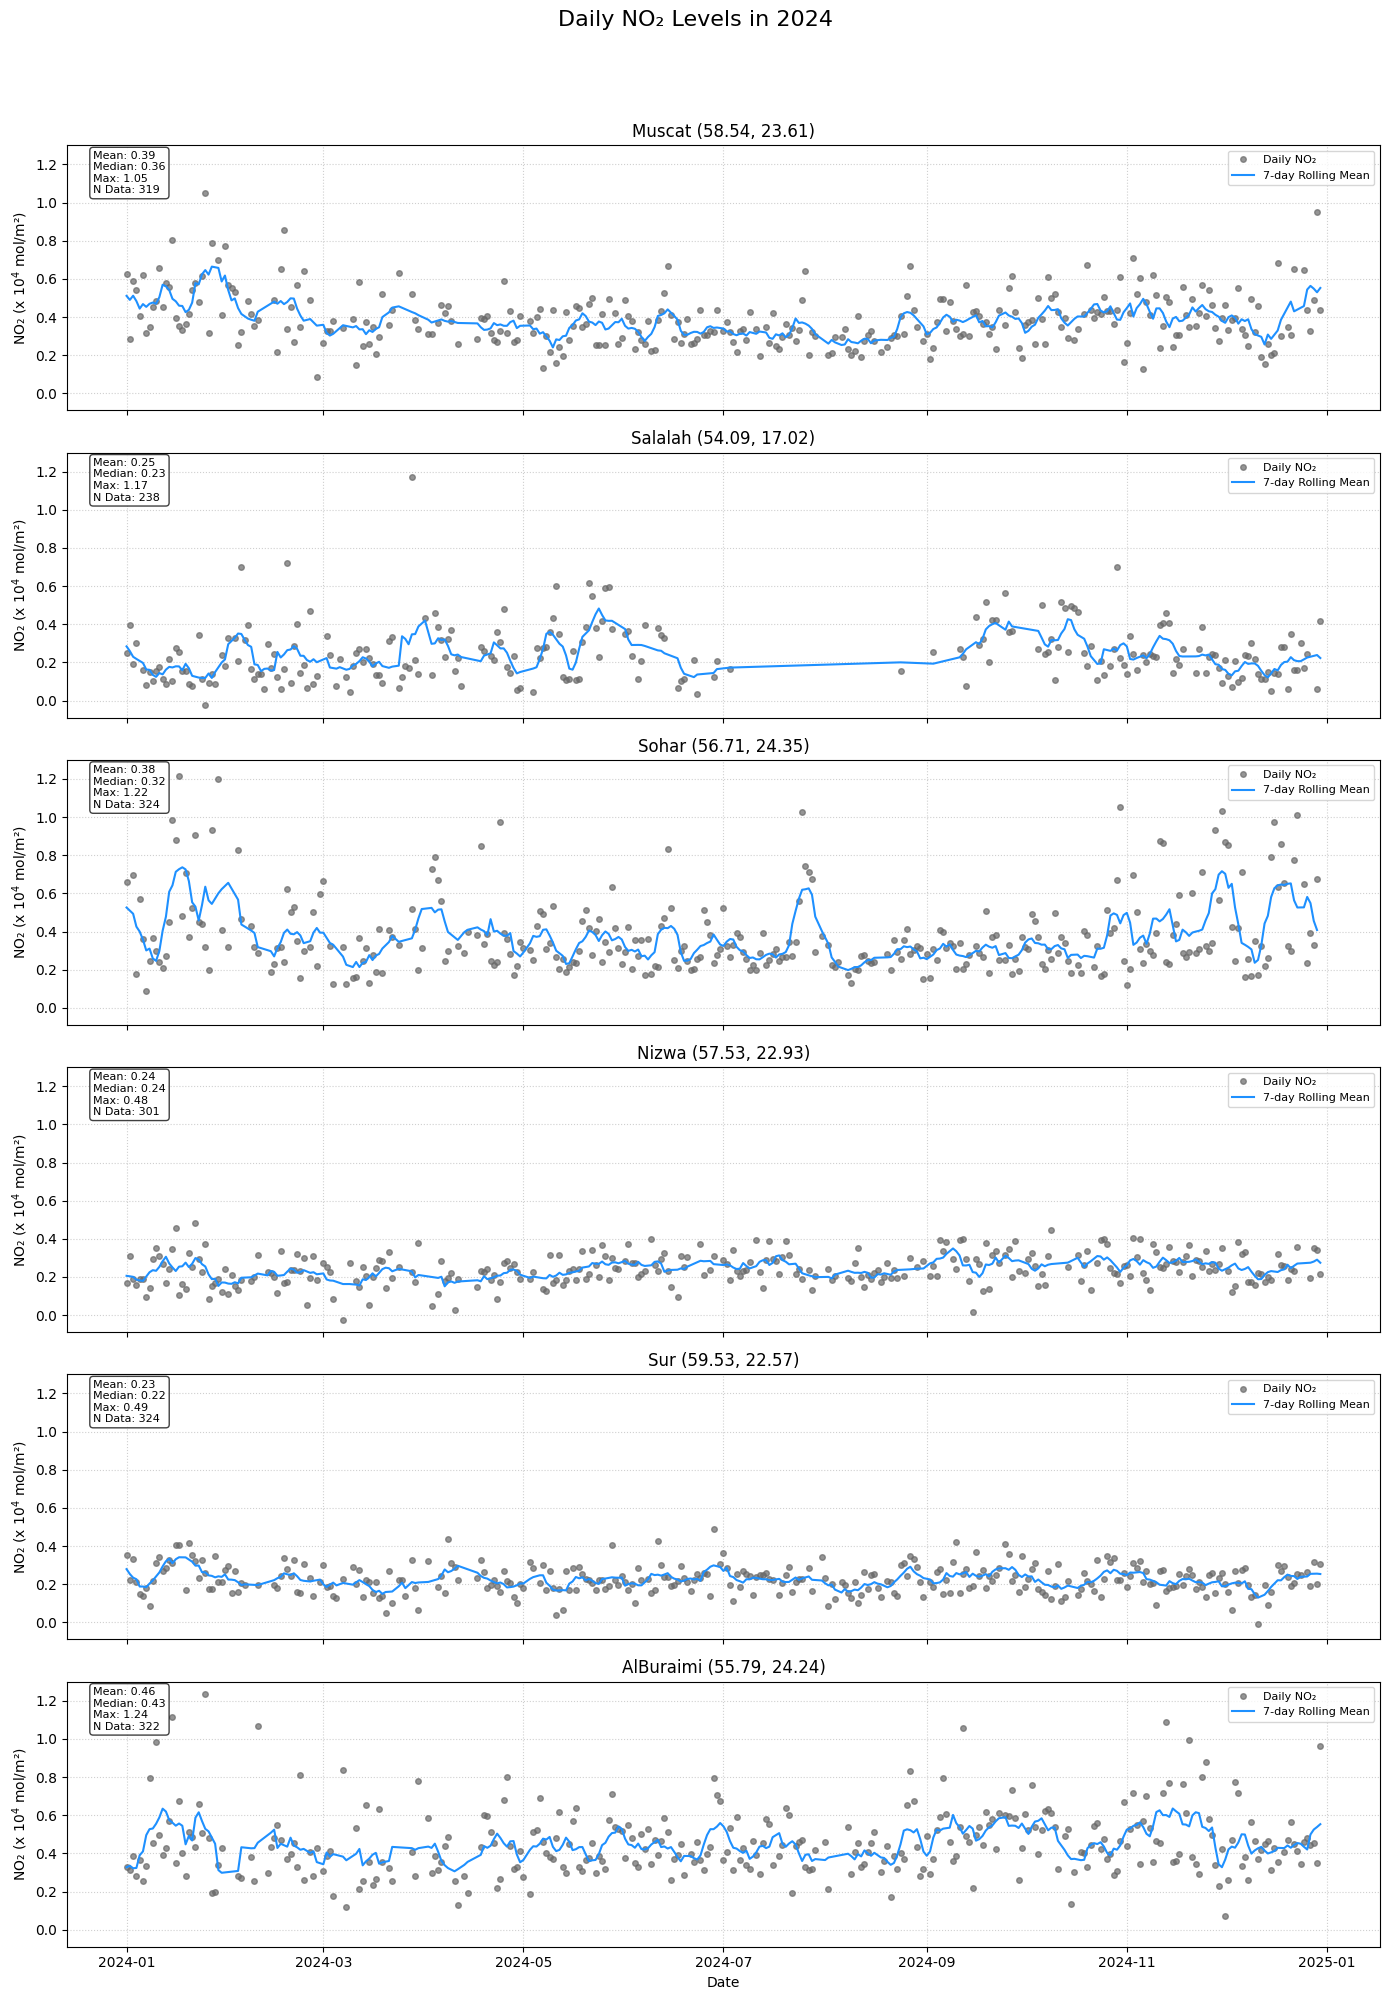

Timeseries plot saved as no2_timeseries_2024.png
Section C (Timeseries Plotting) took: 4.53 seconds.



In [6]:
if city_dfs:
    # ----------------------------------------------------------
    # Section C. Timeseries Plot
    # ----------------------------------------------------------
    section_c_start_time = time.perf_counter()
    print("--- Running Section C: Timeseries Plotting ---")
    num_cities_loaded = len(city_dfs)
    fig, axes = plt.subplots(nrows=num_cities_loaded, ncols=1, figsize=(14, 3.5 * num_cities_loaded), sharex=True, sharey=True, squeeze=False)
    axes = axes.flatten()
    fig.suptitle(f"Daily NO₂ Levels in {TARGET_YEAR}", fontsize=16, y=0.98)

    for i, (city_plot, df_plot) in enumerate(city_dfs.items()):
        ax = axes[i]
        df_plot["NO2_scaled"] = df_plot["NO2"] * 1e4
        df_plot["NO2_7day_scaled"] = df_plot["NO2_scaled"].rolling(window=7, center=True, min_periods=1).mean()

        ax.plot(df_plot["t"], df_plot["NO2_scaled"], marker='o', linestyle='', ms=4, color="dimgray", alpha=0.7, label="Daily NO₂")
        ax.plot(df_plot["t"], df_plot["NO2_7day_scaled"], linestyle='-', color="dodgerblue", lw=1.5, label="7-day Rolling Mean")

        coords = aois[city_plot]["coordinates"]
        ax.set_title(f"{city_plot} ({coords[0]:.2f}, {coords[1]:.2f})")

        mean_val = df_plot["NO2_scaled"].mean()
        median_val = df_plot["NO2_scaled"].median()
        max_val = df_plot["NO2_scaled"].max()
        data_point_count = df_plot["NO2_scaled"].count()

        stats_text = (f"Mean: {mean_val:.2f}\n"
                      f"Median: {median_val:.2f}\n"
                      f"Max: {max_val:.2f}\n"
                      f"N Data: {data_point_count}")
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                fontsize=8, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.75))

        ax.set_ylabel("NO₂ (x $10^4$ mol/m²)")
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(loc='upper right', fontsize=8)

    if num_cities_loaded > 0:
        axes[-1].set_xlabel("Date")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'no2_timeseries_{TARGET_YEAR}.png', dpi=300)
    plt.show()
    print(f"Timeseries plot saved as no2_timeseries_{TARGET_YEAR}.png")

    section_c_end_time = time.perf_counter()
    print(f"Section C (Timeseries Plotting) took: {section_c_end_time - section_c_start_time:.2f} seconds.\n")

##D. Visualization: Boxplot Comparison of Weekday vs. Weekend NO₂ Levels Across Cities

This section creates a boxplot visualization to compare the distribution of daily NO₂ levels between weekdays and weekends for all six selected cities in 2024. Boxplots are excellent for visualizing and comparing the statistical distributions of data across different categories, in this case, day types (weekday vs. weekend) and cities.

**Visualization Objectives:**

*   **Weekday vs. Weekend Comparison:** To investigate if there are systematic differences in NO₂ concentrations between weekdays and weekends within each city.  This can potentially indicate the influence of weekday activities (e.g., traffic, industrial operations) on air pollution levels compared to weekends when activity patterns often change.
*   **Cross-City Comparison of Day-Type Effects:** To compare the magnitude and direction of weekday-weekend differences in NO₂ levels across different cities. Some cities might show a more pronounced weekday-weekend contrast than others, reflecting varying urban activity patterns or pollution control measures.
*   **Distributional Overview:** To visualize the overall distribution of NO₂ values for both weekdays and weekends in each city, showing the median, quartiles, and potential outliers.

**Plot Structure and Elements:**

The code generates a boxplot figure with the following elements:

*   **Combined DataFrame:** First, the code combines the individual city DataFrames (stored in `city_dfs`) into a single Pandas DataFrame called `combined_df`.  This is done using `pd.concat()` and a list comprehension `[df.assign(city=city) for city, df in city_dfs.items()]` to efficiently merge the data and add a 'city' column to identify the origin of each data point.
*   **Boxplot Creation with Seaborn:**  A boxplot is created using the `seaborn.boxplot()` function:
    *   **X-axis: City:** The x-axis of the boxplot represents the different cities.
    *   **Y-axis: NO₂ Level:** The y-axis represents the NO2 concentration values (presumably still the scaled values if you intend to plot `NO2_scaled`, you might need to adjust the column name if you want to plot the original `NO2` column).
    *   **Hue: Day Type:** The `hue="day_type"` parameter is crucial. It splits the boxplots for each city into two boxes side-by-side: one for "Weekday" and one for "Weekend", allowing for direct visual comparison within each city and across cities.
    *   **Palette:** The `palette="Set2"` argument sets the color palette for the boxes, using the "Set2" color scheme from Seaborn for visual appeal and distinction between day types.
*   **Plot Title and Labels:** The plot is given a title "Comparison of NO₂ Levels: Weekdays vs Weekends (2024)", and the axes are labeled "City" for the x-axis and "NO₂ Level" for the y-axis.
*   **Legend:** A legend is added with `plt.legend(title="Day Type")` to clarify which color corresponds to "Weekday" and "Weekend".
*   **Grid:** Horizontal grid lines are added using `plt.grid(axis="y")` to aid in reading the values and comparing box positions visually.
*   **Tight Layout:** `plt.tight_layout()` is used to adjust plot parameters for a clean and compact layout.

**Output:**

*   **`no2_daytype.png`:** A PNG image file of the generated boxplot figure will be saved in your local working directory.
*   **Inline Plot:** The boxplot figure will also be displayed directly in your Google Colab notebook.

**Interpretation:**

By examining this boxplot, you can analyze:

*   **Weekday-Weekend Differences per City:**  For each city, compare the position and spread of the "Weekday" boxplot to the "Weekend" boxplot.  Are weekday NO₂ levels generally higher, lower, or similar to weekend levels? How does the variability differ?
*   **City-to-City Comparisons:** Compare the overall levels and distributions of NO₂ across different cities, for both weekdays and weekends.  Which cities tend to have higher or lower NO₂ levels in general?
*   **Outliers and Data Spread:**  Boxplots also visually represent the spread of the data (interquartile range, whiskers) and show potential outlier data points, which can be relevant for understanding the range and variability of NO₂ concentrations.

This boxplot provides a concise and effective way to summarize and compare the central tendencies and distributions of NO₂ levels in different cities across different day types.

---

--- Running Section D: Weekday/Weekend Boxplot ---


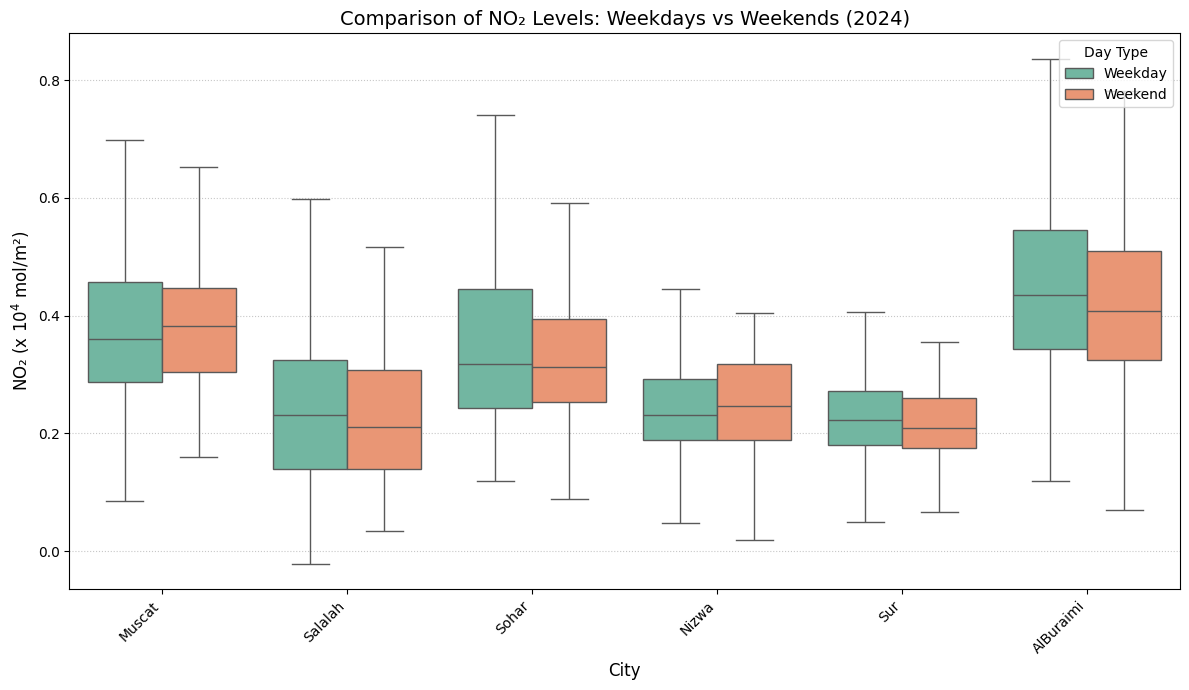

Weekday/weekend boxplot saved as no2_daytype_2024.png
Section D (Weekday/Weekend Boxplot) took: 1.65 seconds.



In [9]:
    # ----------------------------------------------------------
    # Section D. Boxplot: Weekdays vs Weekends
    # ----------------------------------------------------------
    section_d_start_time = time.perf_counter()
    print("--- Running Section D: Weekday/Weekend Boxplot ---")
    combined_df_list = []
    for city_data_key, df_data_val in city_dfs.items():
        if "NO2_scaled" not in df_data_val.columns:
             df_data_val["NO2_scaled"] = df_data_val["NO2"] * 1e4
        combined_df_list.append(df_data_val.assign(city=city_data_key))

    if combined_df_list:
        combined_df = pd.concat(combined_df_list, ignore_index=True)
        plt.figure(figsize=(12, 7))
        sns.boxplot(x="city", y="NO2_scaled", hue="day_type", data=combined_df, palette="Set2", showfliers=False)
        plt.title(f"Comparison of NO₂ Levels: Weekdays vs Weekends ({TARGET_YEAR})", fontsize=14)
        plt.xlabel("City", fontsize=12)
        plt.ylabel("NO₂ (x $10^4$ mol/m²)", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Day Type", loc='upper right')
        plt.grid(axis="y", linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'no2_daytype_{TARGET_YEAR}.png', dpi=300)
        plt.show()
        print(f"Weekday/weekend boxplot saved as no2_daytype_{TARGET_YEAR}.png")
    else:
        print("No data available for weekday/weekend boxplot.")

    section_d_end_time = time.perf_counter()
    print(f"Section D (Weekday/Weekend Boxplot) took: {section_d_end_time - section_d_start_time:.2f} seconds.\n")

##E. Visualization: Seasonal Comparison of NO₂ Levels Across Cities

This final visualization section extends the analysis to explore potential seasonal variations in NO₂ levels across the selected cities.  By categorizing the daily NO₂ data into seasons (Winter, Spring, Summer, Autumn), we can investigate if there are recurring seasonal patterns in air pollution levels and compare these patterns across different geographical locations and climates.

**Analysis Objectives:**

*   **Seasonal NO₂ Patterns:** To identify if there are distinct seasonal patterns in NO₂ concentrations within each city. For example, are NO₂ levels typically higher in winter and lower in summer, or vice versa? Are there specific seasons with more variability in NO₂?
*   **Cross-City Seasonal Comparisons:** To compare the seasonal NO₂ patterns across the six cities. Do cities in similar climate zones exhibit similar seasonal trends? Are there cities where seasonal variations are more pronounced than in others?
*   **Hemispheric Consideration:**  To account for the fact that seasons are reversed in the Northern and Southern Hemispheres. The code explicitly considers the latitude of each city when assigning seasons, ensuring that "Winter" refers to the winter season in both hemispheres, and similarly for other seasons.

**Code Workflow:**

The code performs the following steps to achieve seasonal analysis and visualization:

1.  **Redefine AOIs (Note: Potentially Redundant):**  The code starts by redefining the `aois` dictionary.  **Note:** This step is likely redundant if you have already defined `aois` in the previous code sections. It's included here to ensure the code is self-contained, but in a complete notebook, you would typically use the `aois` dictionary defined earlier.

2.  **Combine Data from All Cities (Note: Potentially Redundant):** Similar to the weekday/weekend boxplot, the code again combines the individual city DataFrames from `city_dfs` into a single `combined_df`. **Note:** This step might also be redundant if `combined_df` from the previous section is still available and you are continuing sequentially in the same Colab session. However, for script independence, it's re-executed here.

3.  **Ensure Datetime and Extract Month:** The code explicitly ensures that the 't' column is parsed as datetime objects using `pd.to_datetime(combined_df["t"])`. It then extracts the month number from the datetime objects and creates a new 'month' column in `combined_df`.

4.  **Define `assign_season` Function:** This is the core of the seasonal analysis. A function `assign_season(row)` is defined to determine the season for each data point based on the month and the city's latitude:
    *   **Latitude-Based Season Assignment:** The function checks the latitude of the city (retrieved from the `aois` dictionary based on the 'city' name in each row).
    *   **Hemispheric Season Logic:**
        *   **Northern Hemisphere (latitude >= 0):**  Standard Northern Hemisphere seasons are assigned (December-February: Winter, March-May: Spring, June-August: Summer, September-November: Fall).
        *   **Southern Hemisphere (latitude < 0):** Seasons are reversed for the Southern Hemisphere (December-February: Summer, March-May: Fall, June-August: Winter, September-November: Spring).
    *   **Season Return:** The function returns the calculated season name ('Winter', 'Spring', 'Summer', or 'Fall').

5.  **Apply Season Assignment:** The `assign_season` function is applied to each row of the `combined_df` using `combined_df.apply(assign_season, axis=1)`. This creates a new column named 'season' in the `combined_df` that contains the season assigned to each daily NO2 measurement.

6.  **Create Seasonal Boxplot:** A boxplot is generated using `seaborn.boxplot()` to visualize the seasonal distribution of NO₂ levels:
    *   **X-axis: City:** The x-axis represents the different cities.
    *   **Y-axis: NO₂ Level:** The y-axis represents the NO₂ level values (again, likely the scaled `NO2` values; ensure column name consistency).
    *   **Hue: Season:** The `hue="season"` parameter splits the boxplots for each city into four boxes, one for each season (Winter, Spring, Summer, Autumn), allowing for seasonal comparison within each city and across cities.
    *   **Palette:**  `palette="Set2"` sets the color scheme for the boxes.
*   **Plot Title, Labels, Legend, and Grid:** The plot is configured with a title "Comparison of NO₂ Levels by Season (2024)", axis labels, a legend for seasons, and horizontal grid lines, similar to the weekday/weekend boxplot.

**Output:**

*   **`no2_seasonal.png`:** A PNG image file of the generated boxplot figure will be saved in your local working directory.
*   **Inline Plot:** The seasonal boxplot figure will be displayed directly in your Google Colab notebook.

**Interpretation:**

By examining this seasonal boxplot, you can analyze:

*   **Seasonal Differences per City:** For each city, compare the positions and spreads of the boxplots across the four seasons. Are there seasons with consistently higher or lower NO₂ levels? How does the variability change by season?
*   **Cross-City Seasonal Patterns:** Compare the seasonal NO₂ patterns across different cities. Do cities in similar latitudes or climate regions exhibit similar seasonal NO2 variations? Are seasonal variations more pronounced in some cities than others?
*   **Influence of Seasonality on Air Quality:** This visualization helps understand the potential influence of seasonal factors (e.g., weather patterns, temperature, vegetation cycles, seasonal human activities) on urban air quality as reflected in NO₂ levels.

This seasonal analysis provides a deeper understanding of the temporal dynamics of NO₂ pollution in these major cities beyond just weekday/weekend variations, revealing potential broader environmental and climatic influences.

---

--- Running Section E: Seasonal Boxplot ---


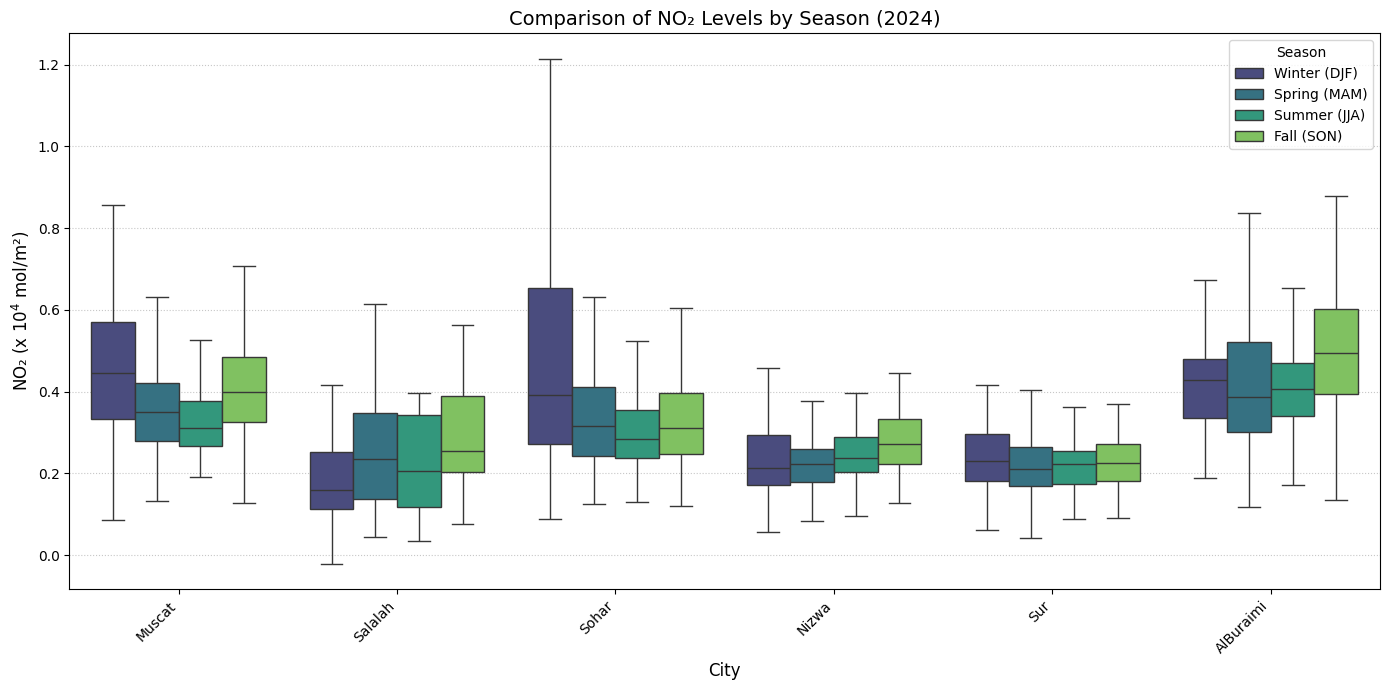

Seasonal boxplot saved as no2_seasonal_2024.png
Section E (Seasonal Boxplot) took: 1.46 seconds.

-------------------------------------------------------------
Total script execution time: 1742.22 seconds (29.04 minutes).
-------------------------------------------------------------


In [10]:
    # ----------------------------------------------------------
    # Section E. Boxplot: Seasonal Analysis
    # ----------------------------------------------------------
    section_e_start_time = time.perf_counter()
    print("--- Running Section E: Seasonal Boxplot ---")
    if combined_df_list:
        combined_df["t"] = pd.to_datetime(combined_df["t"])
        combined_df["month"] = combined_df["t"].dt.month

        def assign_season(row):
            month_val = row['month']
            city_latitude = aois[row['city']]['coordinates'][1]
            if city_latitude >= 0:
                if month_val in [12, 1, 2]: return 'Winter (DJF)'
                elif month_val in [3, 4, 5]: return 'Spring (MAM)'
                elif month_val in [6, 7, 8]: return 'Summer (JJA)'
                else: return 'Fall (SON)'
            else:
                if month_val in [12, 1, 2]: return 'Summer (DJF)'
                elif month_val in [3, 4, 5]: return 'Fall (MAM)'
                elif month_val in [6, 7, 8]: return 'Winter (JJA)'
                else: return 'Spring (SON)'

        combined_df["season"] = combined_df.apply(assign_season, axis=1)
        season_order = ['Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)']

        plt.figure(figsize=(14, 7))
        sns.boxplot(x="city", y="NO2_scaled", hue="season", data=combined_df, hue_order=season_order, palette="viridis", showfliers=False)
        plt.title(f"Comparison of NO₂ Levels by Season ({TARGET_YEAR})", fontsize=14)
        plt.xlabel("City", fontsize=12)
        plt.ylabel("NO₂ (x $10^4$ mol/m²)", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Season", loc='upper right')
        plt.grid(axis="y", linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'no2_seasonal_{TARGET_YEAR}.png', dpi=300)
        plt.show()
        print(f"Seasonal boxplot saved as no2_seasonal_{TARGET_YEAR}.png")
    else:
        print("No data available for seasonal boxplot.")

    section_e_end_time = time.perf_counter()
    print(f"Section E (Seasonal Boxplot) took: {section_e_end_time - section_e_start_time:.2f} seconds.\n")

script_end_time = time.perf_counter()
total_script_duration = script_end_time - script_start_time
print(f"-------------------------------------------------------------")
print(f"Total script execution time: {total_script_duration:.2f} seconds ({total_script_duration / 60:.2f} minutes).")
print(f"-------------------------------------------------------------")

##F. Conclusion: Insights into Urban NO₂ Pollution from Sentinel-5P Time-Series Analysis

This analysis has successfully leveraged the openEO platform and Sentinel-5P satellite data to explore the temporal dynamics of Nitrogen Dioxide (NO₂) pollution in six Omani cities throughout the year 2024. By downloading, processing, and visualizing daily NO₂ level data, we have gained valuable insights into urban air quality patterns and potential influencing factors.

**Summary of Key Findings:**

*   **Time-Series Trends:** The time-series plots for each city revealed the daily fluctuations and overall trends of NO₂ levels throughout 2024.  The application of a 7-day rolling mean helped to smooth out daily variability and highlight underlying seasonal patterns.  Visual inspection of these plots allows for a city-by-city comparison of NO₂ dynamics, showing variations in levels and temporal patterns.
*   **Weekday vs. Weekend Patterns:** The boxplot comparison of weekday and weekend NO₂ levels provided insights into the potential impact of weekday activities on air pollution.  By visually comparing the distributions, we could observe if and to what extent NO₂ levels systematically differ between weekdays and weekends in each city, potentially reflecting changes in traffic, industrial activity, or other anthropogenic emissions.
*   **Seasonal Variations:** The seasonal boxplot analysis, considering hemispheric differences, explored the presence of seasonal cycles in NO₂ pollution. This visualization allowed for the identification of seasons with typically higher or lower NO₂ levels in each city and facilitated a comparison of seasonal patterns across the diverse geographical locations studied.  This might reflect influences of weather patterns, temperature inversions, or seasonal changes in emissions sources.
*   **Data Point Count:**  Including the data point count in the time-series plots provided important context regarding the completeness of the data record for each city throughout 2024. Variations in data point counts could reflect data availability or potential gaps in Sentinel-5P observations.

**Implications and Potential Interpretations:**

The observed patterns and differences in NO₂ levels across cities and time periods can provide valuable information for:

*   **Air Quality Monitoring:**  Understanding the typical levels and temporal variations of NO₂ in these urban areas.
*   **Pollution Source Identification:**  Inferring the potential influence of anthropogenic activities (weekday/weekend differences) and seasonal factors (seasonal variations) on urban air quality.
*   **Comparative Urban Studies:**  Comparing air quality dynamics across cities in different regions and with varying socio-economic and environmental characteristics.
*   **Informing Air Quality Management:** Providing data-driven insights that could inform urban planning, transportation policies, and air pollution mitigation strategies.

**Limitations and Future Directions:**

It's important to acknowledge the limitations of this initial analysis:

*   **Point-Based Data:**  The analysis is based on point measurements of NO₂ concentration at the approximate center of each city. This might not fully represent the spatial variability of NO₂ pollution across the entire urban area.
*   **Data Gaps and Quality:** Sentinel-5P data, like all satellite data, can have gaps due to cloud cover or other factors. Data quality and potential biases in the satellite retrievals should be considered in more in-depth studies.
*   **Simplified Season Definitions:** The seasonal classification used is a simplification.  More refined seasonal definitions or the use of meteorological data could provide a more nuanced understanding of seasonal influences.
*   **Correlation vs. Causation:** While the analysis reveals temporal patterns and correlations, establishing causal relationships between observed NO₂ variations and specific factors (e.g., traffic, weather) would require further investigation and potentially integration with other datasets (e.g., meteorological data, traffic data, emission inventories).

To extend this analysis and gain a more comprehensive understanding of urban NO₂ pollution, future work could consider:

*   **Expanding Spatial Analysis:**  Analyzing NO₂ data across larger urban areas, not just at single points, to capture spatial gradients and intra-urban variations.
*   **Integrating Meteorological Data:**  Combining NO₂ data with meteorological variables (temperature, wind speed, boundary layer height, etc.) to investigate the influence of weather conditions on pollution levels.
*   **Longer Time Series Analysis:**  Analyzing NO₂ data over multiple years to identify inter-annual trends and assess the impact of long-term changes in emissions or policies.
*   **Investigating Specific Events:**  Focusing on specific periods or events (e.g., holidays, industrial shutdowns, policy changes) to examine their impact on NO₂ levels.
*   **Validation and Ground Truth:**  Comparing satellite-derived NO₂ data with ground-based air quality monitoring data for validation and to better understand the accuracy and limitations of the satellite measurements in these urban environments.

*Jakarta, 17 February 2025*
- *Curated by: Alberth Nahas*
- *Email: alberth.nahas@bmkg.go.id*